Note : Readers of this code are expected to have general understanding of Dynamic programming and Supervised learning.<br>
Brief description of the thought process is shared in between, to align the readers, when possible.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Declaring states:
# instead of using ABCDEFG, using 0123456,
# as it is easier to call the call the values.
states = [0,1,2,3,4,5,6]
non_terminal_states = [1,2,3,4,5]


#creating state vectors, with Xi = 1 for ith non terminal state.
initial_states = np.eye(len(states))

initial_weights  = np.ones(len(non_terminal_states))

initial_values = np.zeros(len(states))
initial_values[len(states)-1] = 1
initial_values[1:6] = initial_states[1:6,1:6].dot(initial_weights)

Suttons uses this paper to expand on the effectiveness of the Temporal difference methods.

which, as presented in his research, perform better than supervised learning techniques, in case of "Dynamic state systems"

Additionally TD methods have an edge over Supervised methods in terms of learning at every step of experience and updating the expected prediction, rather than weighting till a experience terminal is reached. And therefore TD methods are proved to be more efficient in learning from the limited experience.


-------------------------

# <u> Chapter 1. Function definitions</u>

## 1. Sequence generator.
a single game sequence generator, to mimic the markovs general process, starting at the middle state "D" and taking right or left steps with 50% probability, until the game reaches the terminal state ( A or G)

however the code is made moldable to start from a different state.

In [3]:
def seq_generator(state = 3,sequence = np.array([])):
    
    #initiallize recording the sequence from the start state
    sequence = np.append(sequence,state)
        
    #generate the sequence until the terminal state is reached.
    while((state < 6) and (state > 0)):

        
        #move left or right from the current state with 50% probability
        state += np.random.choice([-1,1],p=[0.5,0.5])

        sequence = np.append(sequence,state)
        
    return(sequence)

## 2. Test sets generator.

Generates a collection of Test sets, as a record in a ragged arrays of different sequences per test set, using the sequence generator function.


In [4]:
def Test_set_generator(state=3,seed =1,Set_count =10,sequence_count=5):
    Test_sets = []
    np.random.seed(seed)
        
    for i in range(Set_count):

        #creating a list of sequence
        sequence_list = []

        for j in range(sequence_count):

            #generating sequence
            sequence =seq_generator(state = state)
            sequence_list = sequence_list + [sequence]

        Test_sets = Test_sets + [sequence_list]
    return(Test_sets)
    

## 3. Delta W - generator:
learning from a single sequence.

In [5]:
def Dw_generator(state = 3,sequence = np.array([]) ,values = initial_values, lambda_ = 0.1, alpha =0.1):
    

    e = 0
    dw_list  = np.array([])
    
    for n,i in enumerate(sequence[0:-1]):

        #setting State to int
        state = int(i)
        
        
        ################## calculating e: for t = 1, e1  == x1 , it is a vector of length 5
        #other wise et = lambda_*e(t-1) + xt
        e = lambda_*e + initial_states[state][1:6]


        
        ################## calculating dw, : dwt = alpha*(p(t+1) - p(t))*et
        
        #pt = wT.xt
        #p(t+1) = wT.x(t+1)
        # wT is the the same vector used to calculate the pt p(t+1) as mentioned by the paper
        #Addtionally since the value does not change before the test set ends, same values will be used without update for all the states and sequences in the test set.
        
        dw = alpha*( values[int(sequence[n+1])] - values[state] )*e
        

        if n == 0 :
            dw_list  = dw
        else:
            dw_list = np.vstack((dw_list,dw))
    return(dw_list.sum(axis =0))
    #return(dw_list)





## 4. Error calculation - RMSE from the ideal prediction

In [6]:
def rmse(arr_1,arr_2 =[1/6,1/3,1/2,2/3,5/6] ):
    #print(arr_1)
    return np.sqrt(((arr_1 - np.array(arr_2))**2).mean())

----------------------

# Chapter 2: Experiment 1:
learning TD lambda.

In the experiment 1, 

Sutton shows us the how TD method could be more efficient learners as comparied to Supervised learning.
And this experiment also depicts the impact of the repeated presentation, of a set of sequences of the game, to learn from a limited experience of the observed universe.

**why does TD methods perform?**
Sutton mentions, according to (Widrow & Stearns, 1985), the Widrow-Hoff procedure under repeated presentations, minimizes the RMS error between its predictions and the actual outcomes in the training set. 

However, "the Widrow-Hoff procedure only minimizes error on the training set, it does not necessarily minimize error for future experience."

Where as linear TD(0), converges to considered "the optimal estimates for matching future experience" - those consistent with the maximum-likelihood estimate of the underlying Markov process.


--------------------------------------
**Repeated for clarity:**
In the experiment we staudy the impact of different horizons of experience on prediction performance, with different values of "Lambda".

--------------------------------------

Additionally, he has accepted the inherent stochasticity in the game, due to the random walk, which can result in vastly different experiences, and therefore showes biased results based on chance.

to answer this he has averaged the errors, to showcase a general behaviour of the game, over multiple different set of game experiences.

## 1. Procedure definition

The procedure is trying peform the followings:

- for Different Lambda values
- over 100 test sets.
    - learn from the the experience of 10 sequences, where learning is accumilated till the end of a set, and update the expected predictions.
        - Continue to learn from the current training set, till there is no more statistically significant learning observed, with repreated presentation of the training set.
    - calculate the RSME error of expected prediction, updated with learning from the set and the ideal target values.
- average the RMSE error over all the training sets
- store the RMSE average error for different lambda values and compare

In [7]:
def experiment_1(wt_random = False,Test_Sets =np.array([]),initial_weights = initial_weights,seed =1,state = 3, Set_count =10,sequence_count=5, alpha = 0.2,variable_convo = False , wt_conf = 0.5, lambda_ = [0,0.1,0.3,0.5,0.7,0.9,1], convergence=0.001 ):

    if(len(Test_Sets) ==0):
        Test_Sets = Test_set_generator(state=state, seed =seed,
                                   Set_count = Set_count,
                                   sequence_count=sequence_count)        
    
    
    lambda_error_list =[]
    
    for n,gi in enumerate(lambda_):
        
        error_list = []
        
        for q,i in enumerate(Test_Sets):
            track = 0
            dw_update = 1
            
            #
            
            #as mentioned in the paper, the convergence is achiveable with any initial weights for a given small learning rate.
            
            values = initial_values.copy()
            
            if (wt_random):
                weights = np.random.rand(1, 5).reshape(5)
                
            else:
                weights = initial_weights.copy()
                weights = weights*wt_conf
            values[1:6] = initial_states[1:6,1:6].dot(weights)
            
            
            
            ####looping till the change in weights from iterating on the test set is less than 0.0001
            while( True): 

                
                
                #initializing : list of all the dw of 1 test set and all sequence in the test set
                dw_list  = np.array([])
                
                
                
                ####looping on the sequencese of the current test set
                for w,k in enumerate(i):
                    
                    
                    #####calculating the dw for the current sequence
                    
                    dw_sum =Dw_generator(state = 3,sequence = k,values = values, lambda_ = gi, alpha =alpha)
                    
                    
                    #append the sum of dw for the episode in the list of dws for the test set.
                    if(w == 0):
                        dw_list = dw_sum.copy()
                    else :
                        #dw_list = np.vstack((dw_list,dw_sum))
                        dw_list += dw_sum
                
                
                #updating weights after the test sets
                
                #new_weights = np.vstack((weights,dw_list.mean(axis=0))).sum(axis=0)
                dw_update = dw_list
                
                
                
                
                
                #setting convergence critera.
                #the amount of change which can imported is a function of lambda and alpha, and therefore a dynamic critrea of convergence can be created, wrt the minmax change
                if(variable_convo):
                    if(gi*alpha ==0):
                        convergence =convergence
                    else:
                        convergence = gi*alpha*0.5
                    
                
                #checking for convergence, if converged, then break
                if(abs(max(dw_update)) < convergence):
                    #print()
                    break
                
                
                #updating weights and calculating new values
                weights += dw_update
                values[1:6] = initial_states[1:6,1:6].dot(weights)
            
            
            #accumiliated error after learning from 10 sequences
            #why calculating error over values rather than weight?
            #Values are the representation of expected value of the target given the current state. 
            #for this experiment the feature vector defining the state is simply equals to 1 at the state's position in the experiment.
            #however this need not be true in the real world and the state will be defined on multiple different features.
            error_list.append(rmse(values[1:6]))
            
        # average of error of experiencing 10 sequences, over 100 training sets
        lambda_error_list.append(np.mean(error_list))
    return lambda_error_list

## 2. Creating Common Test Sets

A common list of test set is created, before hand rather than creating the test sets on the go:

**Reason:**
- to compare the different performance of different lamda and learning rate.

In [8]:
#create test sets
Test_Sets = Test_set_generator(state=3, seed =1,
                                   Set_count = 100,
                                   sequence_count=10)


## 3. Simulating Game Experiment 1:

**Replication of the Suttons 88, figure 4.**

In [9]:

exp1_errors_list = experiment_1(wt_random = False,Test_Sets = Test_Sets,state = 3, 
                    Set_count =100,sequence_count=10, alpha = 0.01,
                    variable_convo =False,convergence=0.000005, lambda_ = [0,0.1,0.3,0.5,0.7,0.9,1] )

exp1_lambda_errors = pd.DataFrame(data = exp1_errors_list, index = [0,0.1,0.3,0.5,0.7,0.9,1], columns =  ["rmse"])



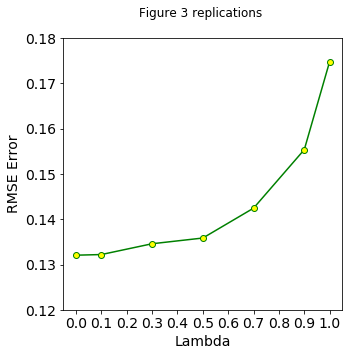

In [10]:


ax_exp1 = exp1_lambda_errors.plot(kind='line', style ='-',color="green",marker ="o",fontsize=14,
                                  markerfacecolor='yellow', legend=False,figsize=(5,5))

ax_exp1.set_title('Figure 3 replications \n')
ax_exp1.set_xlabel("Lambda", fontsize=14)
ax_exp1.set_ylabel("RMSE Error", fontsize=14)

plt.yticks(np.arange(np.round(min(exp1_errors_list),2)-0.01,np.round(max(exp1_errors_list),2)+0.02,0.01))
plt.xticks(np.arange(0,1.1, 0.1))
plt.show()

In [11]:
exp1_errors_list

[0.13205464603992115,
 0.13219659256710584,
 0.134581763667763,
 0.13584385910388047,
 0.14243731714384056,
 0.15535339633834347,
 0.17479689335996149]

**Observations**
1. Based on the methodology shared in the paper by Sutton, error calulated with local simulation , post learning over 10 randomly generated sequences, averaged over 100 test sets, with repeated presentation, is lower than what is shared on the paper, on average by 0.06 -0.07.
2. However the behaviour of the procedure is similar to Sutton's results, as dipected in Figure 3 -erratum, in the paper, that is performance of smaller TD values is better than the larger TD values and subsiquently Supervised Learning algorithms.
    - Therefore, the semulated results support Sutton's statement that TD(Lambda) methods learn more efficiently as compared to Supervised learning methods, as they are moving towards a ideal perediction value


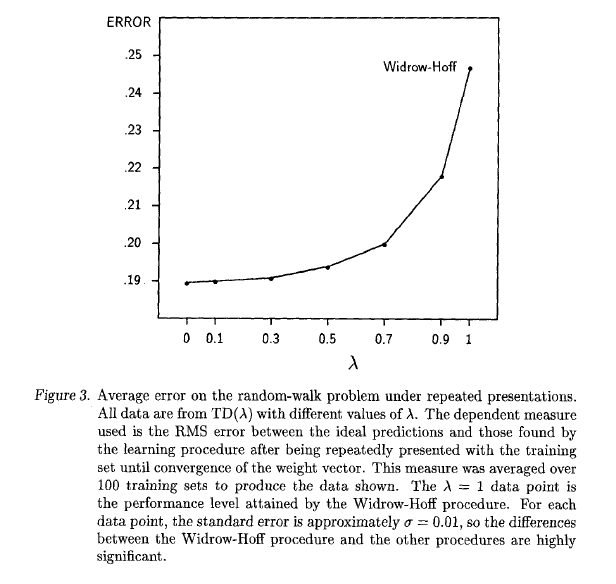


**Hypothesis**:
However, there are some assumptions which can be put to question, as possible reason for the observed deviation.
1. Enough number of Training sets to represent the idea of convergence
2. small learning rate : vagueness in description , how much is small?
3. sequence in set of random states
4. convergence criteria : how much is a significant change?
5. number of sequences per set.
6. Weight initialisation : stated any initial weight will converege.


To study this further, extended learning procedures were performed, As detailed in the annxure.

-------------

# Chapter 3 : Experiment 2 

In [12]:
def experiment_2(Test_Sets =np.array([]),seed =1,state = 3, Set_count =10,sequence_count=5, alpha = 0.2,values = initial_values,initial_states=initial_states, initial_weights=initial_weights, wt_conf = 0.5, lambda_ = [0,0.1,0.3,0.5,0.7,0.9,1], convergence=0.001 ):

    
    #values_lambda_ = np.empty([len(lambda_),len(states)])
    if(len(Test_Sets) ==0):
        Test_Sets = Test_set_generator(state=state, seed =seed,
                                   Set_count = Set_count,
                                   sequence_count=sequence_count)   
    
    lambda_error_list =[]
    
    for n,gi in enumerate(lambda_):

        error_list = []
        
        for q,i in enumerate(Test_Sets):
            track = 0
            dw_update = 1
            
            weights = initial_weights.copy()
            weights = weights*wt_conf
            values[1:6] = initial_states[1:6,1:6].dot(weights)
            
            #looping till the change in weights from iterating on the test set is less than 0.0001

                #initializing : list of all the dw of 1 test set and all sequence in the test set
            dw_list  = np.array([])

            #looping on the sequencese of the current test set
            for w,k in enumerate(i):
                #print(k)
                #calculating the dw for the current sequence
                ##************* should this is individual dw per state or a sum .. **** as to achive MC, it should be the sum of increments of dw

                dw_sum =Dw_generator(state = 3,sequence = k,values = values, lambda_ = gi, alpha =alpha)

                #updating weights and calculating new values
                weights += dw_sum
                values[1:6] = initial_states[1:6,1:6].dot(weights)
                
                error_list.append(rmse(values[1:6]))
        # averaged measure over 100 training sets
        lambda_error_list.append(np.mean(error_list))
    return lambda_error_list

In [13]:

lambda_list = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
alpha_list = np.arange(0,1.1,0.05)
fig_4_lambda = [0,0.3,0.8,1]
error_alpha_lamda_list  = [experiment_2(Test_Sets=Test_Sets,state = 3, Set_count =100,sequence_count=10, alpha = i, lambda_ = lambda_list ) for i in alpha_list]
ex2_error = pd.DataFrame(data = error_alpha_lamda_list, index = alpha_list,  columns =  lambda_list)

ex2_error_fig_4  = ex2_error[fig_4_lambda]
#fiteration
ex2_error_fig_4[ex2_error_fig_4 > 0.65] = np.nan

ex2_error_fig_4.columns =["λ ="+str(i) for i in ex2_error_fig_4.columns]


C:\Users\ashup\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\ashup\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3713: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


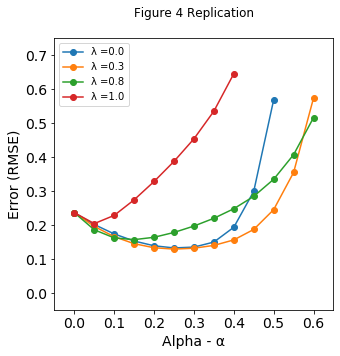

In [14]:

ax_exp2 = ex2_error_fig_4.plot(kind='line', style ='-',marker ="o",fontsize=14,figsize=(5,5))

ax_exp2.set_title('Figure 4 Replication\n')
ax_exp2.set_xlabel("Alpha - α",fontsize=14)
ax_exp2.set_ylabel("Error (RMSE)",fontsize=14)
ax_exp2.legend(fontsize=10)
#ax_exp2.set_ylim(0,0.8)
#ax_exp2.set_xlim(0,0.65)

ax_exp2.autoscale_view()

plt.ylim(-0.05, 0.75)
plt.xlim(-0.05, 0.65)
plt.yticks(np.arange(0,0.8,0.1))
#plt.xticks(np.arange(0,0.65, 0.05))
plt.show()


In [15]:
t = ex2_error.apply(lambda x : x.idxmin(), axis =0).reset_index()
t.columns =["lambda","alpha"]
t["error"]= 0

for i in t.to_records():
    t["error"].loc[i[0]] = ex2_error.loc[i[2],i[1]]


C:\Users\ashup\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


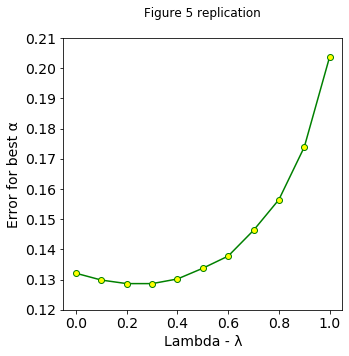

In [16]:

ax_fig5 = t.plot(x = "lambda", y = 'error', kind='line', style ='-',color="green",marker ="o",
                                  markerfacecolor='yellow',fontsize=14,legend=False,figsize=(5,5))

ax_fig5.set_title('Figure 5 replication\n')
ax_fig5.set_xlabel("Lambda - λ",fontsize=14)
ax_fig5.set_ylabel("Error for best α",fontsize=14)

plt.yticks(np.arange(np.round(min(t['error']),2)-0.01,np.round(max(t['error']),2)+0.02,0.01))
#plt.ax_fig5(np.arange(0,1.1, 0.1))
plt.show()


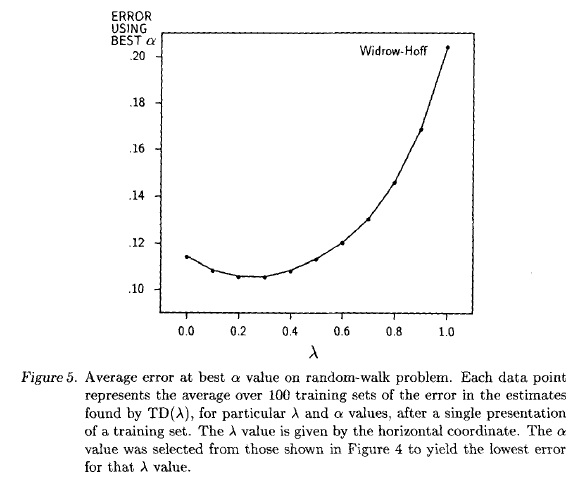

# Annxure 

-------------------------

All further studies are being performed by changing **One** parameter at a time from the orignal experiments.

This is done to limit the number of tests, covering the study of effect of all parameters.

## Expanding Experiment 1

**Hypothesis**:
There are some assumptions, used or marked in Sutton's experiment, which are not clear and can be put to further inquiry for clarifications, as possible reason for the observed deviation.
1. Enough number of Training sets to represent the idea of unbiased convergence 
2. number of sequences per set.
3. small learning rate
4. convergence criteria
5. Weight initialisation : stated any initial weight will converege. ( fixed vs variable weights)
6. different random sequences set of test sets
7. non random sequences ( not being tested)




what is not studied:
    
    - Time taken for convergence 
    - Average length of different sequences and there effect on performance ( error and time of processing)
    - changing the game :
        - start from a different state.
        - different step probabilities.

### <u>Test 1</u> : varaince in performance over different set of test sets

In [ ]:
exp1_errors_list_E1 = [ experiment_1(wt_random = False ,state = 3, 
                    Set_count =i,sequence_count=10, alpha = 0.01,
                    variable_convo =False,convergence=0.000005, lambda_ = [0,0.1,0.3,0.5,0.7,0.9,1] ) for i in [20,100,200,500]]

exp1_lambda_errors_E1 = pd.DataFrame(data = exp1_errors_list_E1, index = ["Test_Sets:"+str(i) for i in [20,100,200,500]], columns =  [0,0.1,0.3,0.5,0.7,0.9,1] ).T



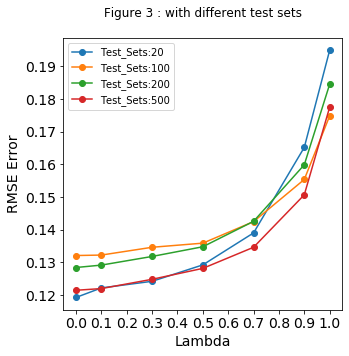

In [604]:
ax_exp1_E1 = exp1_lambda_errors_E1.plot(kind='line', style ='-',marker ="o",fontsize=14,legend=True,figsize=(5,5))

ax_exp1_E1.set_title('Figure 3 : with different test sets\n')
ax_exp1_E1.set_xlabel("Lambda",fontsize=14)
ax_exp1_E1.set_ylabel("RMSE Error",fontsize=14)
ax_exp1_E1.legend(fontsize=10)

#plt.yticks(np.arange(np.round(min(exp1_errors_list),2)-0.01,np.round(max(exp1_errors_list),2)+0.02,0.01))
plt.xticks(np.arange(0,1.1, 0.1))
plt.show()


**Observation**:
based on the above graph, given a small Alpha and convergence criteria, increasing the number of sets does not show any tangible change in the performance of the procedure.

However, it is possible that this observation is biased based on the kinda of sequences generated for analysis by chance.
- to ensure the correctness of the above statements, multiple itterations of the tests are recommended to be performed.
-(Note: this is not being performed)

**Hypothesis**: Since, Addition of number of sets to average the total error of learning, reduces the variance in the observations. it is possible that we may see high variance in the less number of sets, and therefore high errors.

#### Test 1 : *Hypothesis 1* -----------------------------------------------------------------

Running the test for lower number of test sets

In [ ]:
exp1_errors_list_E1_H1 = [ experiment_1(wt_random = False ,state = 3, 
                    Set_count =i,sequence_count=10, alpha = 0.01,
                    variable_convo =False,convergence=0.000005, lambda_ = [0,0.1,0.3,0.5,0.7,0.9,1] ) for i in [1,2,3,4,5,10,15,20]]

exp1_lambda_errors_E1_H1 = pd.DataFrame(data = exp1_errors_list_E1_H1, index = ["Test_Sets:"+str(i) for i in [1,2,3,4,5,10,15,20]], columns =  [0,0.1,0.3,0.5,0.7,0.9,1] ).T


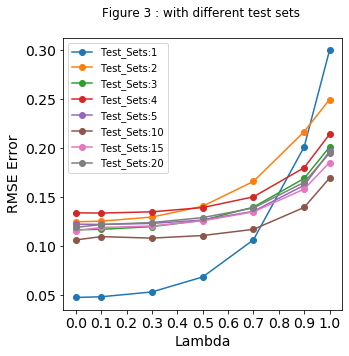

In [605]:
ax_exp1_E1_H1 = exp1_lambda_errors_E1_H1.plot(kind='line', style ='-',marker ="o",fontsize=14,legend=True,figsize=(5,5))

ax_exp1_E1_H1.set_title('Figure 3 : with different test sets \n')
ax_exp1_E1_H1.set_xlabel("Lambda",fontsize=14)
ax_exp1_E1_H1.set_ylabel("RMSE Error" ,fontsize=14)
ax_exp1_E1_H1.legend(fontsize=10)
#plt.yticks(np.arange(np.round(min(exp1_errors_list),2)-0.01,np.round(max(exp1_errors_list),2)+0.02,0.01))
plt.xticks(np.arange(0,1.1, 0.1))
plt.show()

**Results** :
1. All the procedure, share the same behaviour as depicted in Sutton's 1988, experiment 1, figure 3. Additionally, **Sutton's assumption of taking "100" Test sets can be considered statistically enough , to avoid any variance in estimation due to very low number of Test sets.**
2. Error for Test Set 1 has the highest range throughout differnt lambda values, this variance is possibly because of the limited exposure. As dipected above even adding one more test set in the experience reduces this variance to a large extent. ( excluding from further analysis )
3. Except Test Set count = 2 and 1, all the other sizes of set of test sets share approximate the same range.
    - with increase in lambda ( from 0 to 1) the increase in error is higher for Test_set count 2 as compared to other number of test sets .
    - TD(0) performes the best regardless of the number of test set, therefore proving that the TD(0) learns more efficiently from the limited experience, as compared to larger lambda values, for the given set of parameters.
4. Overall error of Test set count = 10 is lower than other sets,  this is assumed to be by chance creation of more suitable sequences for better conversion.
    - Note : nature of sequences such as length or order is not being studied in these tests. however this may hold valuable insights.

**Hypothesis** : based on the above results and the number of states in the model may effect the minium number of training sets:
    - It is possible, that given a limit to number of sequences in a test set, learning rate, and convergence criteria, the minimum number of test sets to achieve low variance and predictions closer to the ideal prediction is dependent on the number of states for a markovian general process for a specific set of transition probabilities.
    <br><u>( NOTE : not being tested)</u>

### Test 2: varaince in performance, different set size -----------------------------------------------------------------------

In [ ]:
exp1_errors_list_E2 = [ experiment_1(wt_random = False ,state = 3, 
                    Set_count =100,sequence_count=i, alpha = 0.01,
                    variable_convo =False,convergence=0.000005, lambda_ = [0,0.1,0.3,0.5,0.7,0.9,1] ) for i in [5,10,15,20]]

exp1_lambda_errors_E2 = pd.DataFrame(data = exp1_errors_list_E2, index = ["set size:"+str(i) for i in [5,10,15,20]], columns =  [0,0.1,0.3,0.5,0.7,0.9,1] ).T


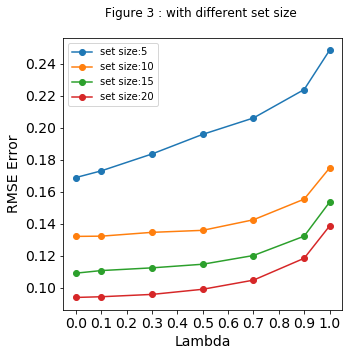

In [606]:
ax_exp1_E2 = exp1_lambda_errors_E2.plot(kind='line', style ='-',marker ="o",fontsize=14,legend=True,figsize=(5,5))

ax_exp1_E2.set_title('Figure 3 : with different set size \n')
ax_exp1_E2.set_xlabel("Lambda",fontsize=14)
ax_exp1_E2.set_ylabel("RMSE Error",fontsize=14)
ax_exp1_E2.legend(fontsize=10)

#plt.yticks(np.arange(np.round(min(exp1_errors_list),2)-0.01,np.round(max(exp1_errors_list),2)+0.02,0.01))
plt.xticks(np.arange(0,1.1, 0.1))
plt.show()

**Observation**:
1. Based on the the above graph, it can be concluded that with increase in exposure to the environment, ie. with more number of sequences to learn from in a test set, the procedure produces predictions much closer to the ideal prediction.
    - possible reason : with increase in the number of sequence the variance in the weight updates are reduced, normaizing the effect of any exceptional sequences.

2. The above conclusion can be made for all lambda values, additionally, procedure with lambda =0 predicts much closer to the ideal prediction, and therefor proving,
    - whereas model with Lambda = 1 gives the worse performance for a given set size.
    - Supporting the statement, as mentioned by sutton in the paper that, Procedures with Lambda 0 are more efficient learners. As they are converging towards as better estimate as compared to Widrow-Hoff procedure 
3. **Intersting find** : when the procedure "can" have more exposure to the environment, even if lambda = 0 gives the best prediction, <u>it might be benificial to use slightly higher values of lambda, than 0</u>, for other set parameters.
    - There is very less difference between the prediction of Lambda = 0 and other lower values of Lambda.
    - Since Lambda = 0 will take more number of <u>repeated presentations</u>, due to its lower range of propogation per episode expereince, 
        -it might be benificial to utilize other lower values of lambda, for example 0.3 - based on the above graph, as the propogation is deeper in the states and therfore, with lesser number of itterations, and almost the same results could be achived in lesser amount of time (or processing).

4. **It is not clear, why Sutton chose "10" sequences per set as statistically significant experience for learning,** as depicted in the graph the higher number of sequences per set procure predictions of the ideal prediction.
    - Possible reason : It is possible that Sutton had assumed a set size based on the RMSE error being atmost of **0.25** for all lambda value, as per the Figure 3 in the paper. or it was selected for the ease of processing.
    -However in his paper "Temporal difference networks with Eligibility Traces 2005" he has considered RMSE<0.05 as a good error value, for TD(1).

- **more explored as part of Experiment 2, but without repeated presentation**


### Test 3: Variance in performance, learning rate-------------------------------------------------------------------------

In [ ]:
exp1_errors_list_E3 = [ experiment_1(Test_Sets=Test_Sets, wt_random = False ,state = 3, 
                    Set_count =100,sequence_count=10, alpha = i,
                    variable_convo =False,convergence=0.000005, lambda_ = [0,0.1,0.3,0.5,0.7,0.9,1] ) for i in [0.01,0.005, 0.001]]



exp1_lambda_errors_E3 = pd.DataFrame(data = exp1_errors_list_E3, index = ["α:"+str(i) for i in [0.01,0.005, 0.001]], columns =  [0,0.1,0.3,0.5,0.7,0.9,1] ).T


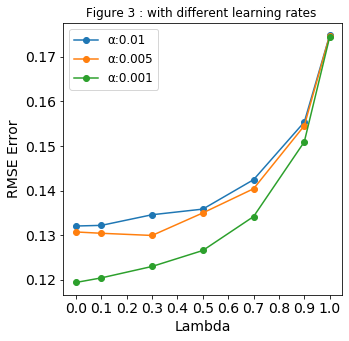

In [607]:
ax_exp1_E3 = exp1_lambda_errors_E3.plot(kind='line', style ='-',marker ="o",fontsize=14,legend=True,figsize=(5,5))

ax_exp1_E3.set_title('Figure 3 : with different learning rates ')
ax_exp1_E3.set_xlabel("Lambda",fontsize=14)
ax_exp1_E3.set_ylabel("RMSE Error", fontsize=14)
ax_exp1_E3.legend(fontsize=12)

#plt.yticks(np.arange(np.round(min(exp1_errors_list),2)-0.01,np.round(max(exp1_errors_list),2)+0.02,0.01))
plt.xticks(np.arange(0,1.1, 0.1))
plt.show()

**Observations**
1. Smaller learning rates, procure better predictions over differ elgibility criteria.
    - possible reason : if learning rate is large, the changes in the weights ar large and the learning will proceed quicker, but it does not have high precisions at the time of convergence, and may overshoot the minimum value change required to get to the ideal predictions.
    - Where as the smaller Learning rate, eventhough slowly, eventually reaches higher precisions.
2. Better predictions are achived at lower lambda values even for lower learning rate, but there is less difference between the predictions made at the higher values of lambda:
    - possible reason : change in the weights is a factor of lambda as well as learning rate, alpha, and at higher lambda values, the impact due to aplhda is reduced, due to polinomial relationship of the change and lambda as compared to alpha, and therfore higher weightage to lambda.
    
**Conclusion:** 
1. Based on the above observations, if there is a limit that the environment can only be observed at the end of an episode, and faster decisions are to be made, than it might be benificial to work with larger values of alpha, for faster convergence.
2. Even if the environment is accessible to the procedure at smaller intervals of time during a episode, it might be benificial to use adaptive learning rate, which decreases with time, to make larger changes to initial assumptions for faster convergence and smaller changes later to attain higher precision.
(NOTE : time take to converge is not being studied, however may add actionable insights)

### Test 4: variance in performance over different convergence criteria ------------------------------------------------

In [ ]:
exp1_errors_list_E4 = [ experiment_1(Test_Sets=Test_Sets, wt_random = False ,state = 3, 
                    Set_count =100,sequence_count=10, alpha = 0.01,
                    variable_convo =False,convergence=i, lambda_ = [0,0.1,0.3,0.5,0.7,0.9,1] ) for i in [0.05,0.005,0.0005,0.00005,0.000005]]

exp1_lambda_errors_E4 = pd.DataFrame(data = exp1_errors_list_E4, index = ["ɛ:"+str(i) for i in [0.05,0.005,0.0005,0.00005,0.000005]], columns =  [0,0.1,0.3,0.5,0.7,0.9,1] ).T

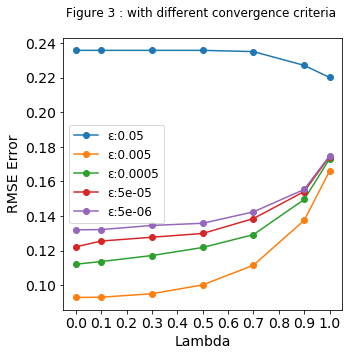

In [619]:
ax_exp1_E4 = exp1_lambda_errors_E4.plot(kind='line', style ='-',marker ="o",fontsize=14,legend=True,figsize=(5,5))

ax_exp1_E4.set_title('Figure 3 : with different convergence criteria \n')
ax_exp1_E4.set_xlabel("Lambda",fontsize=14)
ax_exp1_E4.set_ylabel("RMSE Error", fontsize=14)
ax_exp1_E4.legend(fontsize=12)

#plt.yticks(np.arange(np.round(min(exp1_errors_list),2)-0.01,np.round(max(exp1_errors_list),2)+0.02,0.01))
plt.xticks(np.arange(0,1.1, 0.1))
plt.show()

**Observations**


1. For the convergence criteria threshold = 0.05, the model is not convergin towards the ideal estimates.
-possible reason.
Model's learning and changes in the weights are depenent on learning rate and eligibility criteria. if the convergence criteria is easily met by the model, without making any changes to the existing weights, the model will stop learning early and therefore will fail to move towards the ideal values.


- maximum minimum change is defined by the 1st sequence in the set and the state before reaching the terminal state
- **alpha . (p(T) - p(T-1) .lambda^0 . x(T-1)**
 - = 0.01 x 0.5 x 1 x 1 = 0.005

therefore any convergence criteria less than 0.005, for the given model will probably fail to lead to the ideal estimate convergence

2. **Interesting find** : <u> as the convergence criteria decreases below 0.005, the average error increases.</u>
    - unable to describe the possible reason:
        - observational reason : for a given set of model parameters, the converence to the ideal estimates, can be achived  with the the min-max change as the convergence criteria, and as the lower values may add noise to the data.
        - Additionally, it is possible if the learning reate is higher, and the change has not made the convergence criteria, with miniscule amount, and additional change might overshoot the ideal prediction and may converge to a higher error but low change prediction.






### Test 5: variance in performance over variable and fixed weights ------------------------------------------------

In [ ]:

exp1_errors_list_E5 = [ experiment_1(Test_Sets=Test_Sets, wt_random = i[0], wt_conf = i[1] ,state = 3, 
                    Set_count =100,sequence_count=10, alpha = 0.01,
                    variable_convo =False,convergence=0.000005, lambda_ = [0,0.1,0.3,0.5,0.7,0.9,1] ) for i in [(False, 0),(False,0.5),(False, 0.8),(False, 0.99),(False, 1), (True,0.5)]]



exp1_lambda_errors_E5 = pd.DataFrame(data = exp1_errors_list_E5, index = ["init_weight:"+str(i) for i in [0,0.5,0.8,0.99,1,"random"]], columns =  [0,0.1,0.3,0.5,0.7,0.9,1] ).T


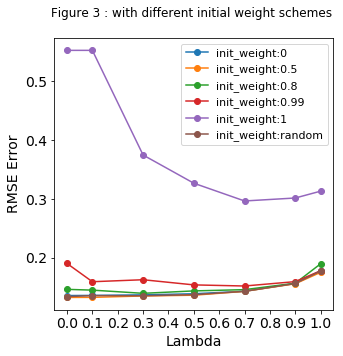

In [620]:
ax_exp1_E5 = exp1_lambda_errors_E5.plot(kind='line', style ='-',fontsize=14,marker ="o",legend=True,figsize=(5,5))

ax_exp1_E5.set_title('Figure 3 : with different initial weight schemes \n')
ax_exp1_E5.set_xlabel("Lambda", fontsize=14)
ax_exp1_E5.set_ylabel("RMSE Error", fontsize=14)
ax_exp1_E5.legend(fontsize=11)
#plt.yticks(np.arange(np.round(min(exp1_errors_list),2)-0.01,np.round(max(exp1_errors_list),2)+0.02,0.01))
plt.xticks(np.arange(0,1.1, 0.1))
plt.show()

**Observations**

1. when the weights is equal to 1. for all non terminal states, along with the one of the terminal states. the models throughout find it hard to converge to the ideal estimate:
    - Additionally the model performs the worst for **lambda = 0**
    - general reason: since the value of all states the except one are equally high, the model does not see high benifit in converging to "G" as compared to staying or occilating between any other state, until it observes an example of a sequence ending in "A".
    - for a simple example of : Values = [0,1,1,1,1,1,1] , alpha = 0.01, lambda = 0 and for a sequence of [DEFG]
        - the dw = [0,0,0,0,0]
        - as there is no positive change, this sequence is not preferable for the model.
    - The sequences are generated randomly, and therefore there is a chance that out of 100 sequences first 50 are ending with "G" as a terminal state and there is no learning for these 50 sequences.
        - which is specifically worse for **lambda = 0** because, even if it is tries to converge to a better estimate, the propogation is slow, and is therfore the 100 of sets are possibly not enough to completely learn.
        

- In this case, the lambda = 1 is one of the best performers, as even from the low number of sequences ending with "A", the the change propogated is propogated throughout the states.

- lambda values less than 1 but still high ( like 0.7), limit the variance partially, and perform better than lambda = 1, but still propogate the change through large number of states. 


**Conclusion** : Therefore, if there is a process where the harmful(unable to find a better word) exception  identification is required, higher values of lambda perform better or possibly converege faster, given the same number of expereince, on comparison with lambda values near 0.

**Note** : Why values are quoted and not weights? : possibly because the updates are a function of states_variables, along with weights in a general sense. Although for this game, the values and the weights equate as state variables = 1 for the ith state and ith component in the state_variables ( or feature vector)

**Test 5 : extension** --------------------------------------------

In [ ]:
exp1_lambda_errors_E5_2 = exp1_lambda_errors_E5[["init_weight:"+str(i) for i in [0,0.5,0.8,0.99,"random"]]]

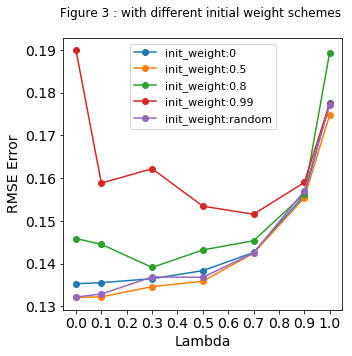

In [621]:

ax_exp1_E5_2 = exp1_lambda_errors_E5_2.plot(kind='line', style ='-',fontsize=14,marker ="o",legend=True,figsize=(5,5))

ax_exp1_E5_2.set_title('Figure 3 : with different initial weight schemes \n')
ax_exp1_E5_2.set_xlabel("Lambda", fontsize=14)
ax_exp1_E5_2.set_ylabel("RMSE Error", fontsize=14)
ax_exp1_E5_2.legend(fontsize=11)
#plt.yticks(np.arange(np.round(min(exp1_errors_list),2)-0.01,np.round(max(exp1_errors_list),2)+0.02,0.01))
plt.xticks(np.arange(0,1.1, 0.1))
plt.show()

**Observations**

2. Procedures with very higher initial weights (0.99), are still showing high errors, as mentioned above, there are low changes for terminating into "G" and therfore learning is slow, for lambda = 0 ,  however these are low as compared to weight initialized at 1, and is comparable to lambda =1 procedures.

3. Procedures for initial weights equal or lower to 0.8 show comparable results throughout the range of lambda ( between 0 -1) for the set parameters. Partially alliging with Sutton's statement on page 20. however not completely.



Note: essentailly high values, such as 0.8,0.99, 1, are those values with low difference from the desired state.


**Conclusion** : 

1. <u><font color ='red'>**Contrary to Sutton's following statement :** </font></u>, as mentioned on in the paper.: 

- **"**<u>Each training set was presented repeatedly to each learning procedure until the procedure no longer produced any significant changes in tile weight vector. For small alpha, the weight vector always converged, and always to the same final value, independent, of its initial value.</u>**"**

- based on the above Observersations, **we fail to prove** that with any initial weight values, the vectors will always converge to the same final values, with repeated presentation. Assuming "0.000005" is the statistically significant small change and "0.01" is a small learning rate.
    - As shown in the figure above, the statement can be corrected, with the above mentioned assumptions, that , All initial weights "producing values statistically significant difference from Desired Terminal state" , on repeated presentation, are **highly likely** to converge a "close" vicinity of any eachother at any lambda between 0 and 1.
        - "significant difference" is subjective to further study, as for this experiment, initial weights below or equal to 0.8 show similar behaviour.
        - "Close" vicinity, follows the same argument.
    
- <u>Based on a extended observations, A specific amendment can also be given:</u>   
    - on repeated presentation, the final weights for all the initial weights "producing values statistically significant difference from Desired Terminal state", will be within a distance of +-0.014161 from any observed final weight value for any initial weight "producing values statistically significant difference from Desired Terminal state", with a 95% confidence Level, based on maximum deviation observed, at any lambda between 0 and 1. (For the observed data.)
    - please note this is required to be further tested.
    - How this number was calculated? 
        - based on the maximum std deviation observed at all the lambda values with 1.96*Z, marking the largest 95% confidence interval on the graphs. 



2 .The performance did not improve for "all initial weights" as lambda is reduced below 1 to 0, contrary to figure 3. Specifically for large initial weights. ( 0.8,0.99,1)
    - This may lay doubts Sutton's following statment, and therfore is required to be tested ( Hypothesis 1:
    - "With asymptotic predictions for a training set of the ideal prediction, Averaging error over training sets,the performance improved rapidly as lambda was reduced below 1 (the supervised-learning method) and was best at lambda = 0 (the extreme TD method)."



**Hypothesis**: to further study the high initial weights.
1. It is possible, given more data, thar a high initial weight and low lambda value can converge closer to the ideal prediction:
    - possible use case: low memory or limited compulation, and urgency, And large data, Along with limitations on starting with only high weights.( based on past experiences, or expectations) 
        -  Need to further study why would someone want to start with high weights for this experiment, or with very low weight difference between the terminal and non-ternimal states
            - Note : Not being done for the project
    

2. Weight initialized to values much closer to ideal values may converge faster. ( not being tested)

#### Test 5: *Hypothesis 1* ----------------------------------------------------------------------------------
more data can result in better conversions even with high initial weights

In [ ]:
exp1_errors_list_E5_H1 = [ experiment_1(wt_random = False, wt_conf = 0.99 ,state = 3,seed =1, 
                    Set_count =100,sequence_count=i, alpha = 0.01,
                    variable_convo =False,convergence=0.000005, lambda_ = [0,0.1,0.3,0.5,0.7,0.9,1] ) for i in [5,10,15,20] ]



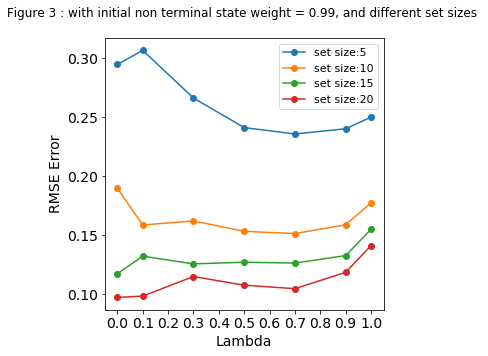

In [622]:


exp1_lambda_errors_E5_H1 = pd.DataFrame(data = exp1_errors_list_E5_H1, index = ["set size:"+str(i) for i in [5,10,15,20]], columns =  [0,0.1,0.3,0.5,0.7,0.9,1] ).T
ax_exp1_E5_H1 = exp1_lambda_errors_E5_H1.plot(kind='line', style ='-',marker ="o",fontsize=14,legend=True,figsize=(5,5))

ax_exp1_E5_H1.set_title('Figure 3 : with initial non terminal state weight = 0.99, and different set sizes \n')
ax_exp1_E5_H1.set_xlabel("Lambda", fontsize=14)
ax_exp1_E5_H1.set_ylabel("RMSE Error", fontsize=14)
ax_exp1_E5_H1.legend(fontsize=11,loc='upper right')

#plt.yticks(np.arange(np.round(min(exp1_errors_list),2)-0.01,np.round(max(exp1_errors_list),2)+0.02,0.01))
plt.xticks(np.arange(0,1.1, 0.1))
plt.show()


**Results:**
1. With the increase in the amount of experience to learn from, per test set, the model was able to come closer to the ideal estimate of the target, throughout the distribution of lambda.
2. with increase in amount of experience, lower values of lambda, such as 0, is peforming better as compared to other lambda values, oppose to the low expereince procedures.  

and therefore these observations, <u><font color='blue'> **may supports Sutton's Statement**, as marked in conclusion 2 above, </font></u> for any weight, given a "significant" amount of experience. i.e with asymptotic predictions for a training set of the ideal prediction, Averaging error over training sets,the performance improved rapidly as lambda was reduced below 1 (the supervised-learning method) and was best at lambda = 0 (the extreme TD method).


**Conclusion**, Even though Sutton's statement is presumably right, however, for real life scenarios, it is not possible to asymptotically predict, due to limited information/expereinces, therefore, it may not be possible to achieve predictions close to ideal predictions, for High initial weights, as it would be impractical. And therefore initial weights should be carefully selected to make best use of the available data. In this specific case the weights of concern are "high", however, the effect is due to low difference between the Desired terminal state and non terminal states.



Please note the time taken for conversion is not being analyzed. and may give some insights

#### Test 5: Hypothesis 1 - Extension with Test 1

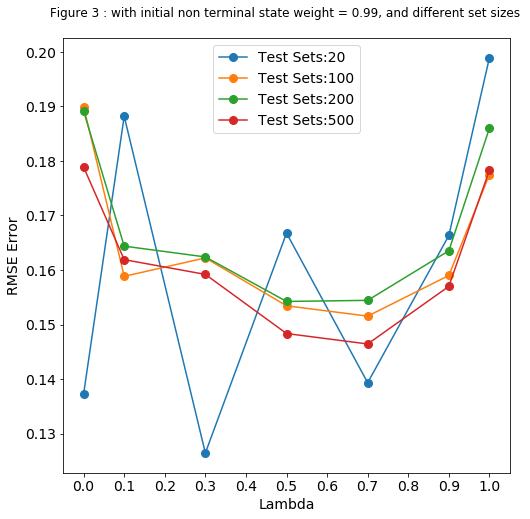

In [562]:
exp1_errors_list_E5_H2 = [ experiment_1(wt_random = False, wt_conf = 0.99 ,state = 3,seed =1, 
                    Set_count =i,sequence_count=10, alpha = 0.01,
                    variable_convo =False,convergence=0.000005, lambda_ = [0,0.1,0.3,0.5,0.7,0.9,1] ) for i in [20,100,200,500] ]



exp1_lambda_errors_E5_H2 = pd.DataFrame(data = exp1_errors_list_E5_H2, index = ["Test Sets:"+str(i) for i in [20,100,200,500]], columns =  [0,0.1,0.3,0.5,0.7,0.9,1] ).T
ax_exp1_E5_H2 = exp1_lambda_errors_E5_H2.plot(kind='line', style ='-',marker ="o",fontsize=14, ms= 8,legend=True,figsize=(8,8))

ax_exp1_E5_H2.set_title('Figure 3 : with initial non terminal state weight = 0.99, and different set sizes \n')
ax_exp1_E5_H2.set_xlabel("Lambda",fontsize=14)
ax_exp1_E5_H2.set_ylabel("RMSE Error",fontsize=14)
ax_exp1_E5_H2.legend(fontsize=14)

#plt.yticks(np.arange(np.round(min(exp1_errors_list),2)-0.01,np.round(max(exp1_errors_list),2)+0.02,0.01))
plt.xticks(np.arange(0,1.1, 0.1))
plt.show()


**Observations**:
    
    - As observed in Test 2, here as well, the lower number of Test sets have higher variance, even for high weight values, However, ther general pattern as depicted in figure 3 is not followed.
    - Based on the above, for high weight (values with insignificant difference from desired terminal states) should be subjected to larger number of test sets, to remove change variance, as compared to lower weights

### Test 6: variance in performance over different set of test sets

In [ ]:
exp1_errors_list_E6 = [ experiment_1(wt_random = False,seed = i ,state = 3, 
                    Set_count =100,sequence_count=10, alpha = 0.01,
                    variable_convo =False,convergence=0.000005, lambda_ = [0,0.1,0.3,0.5,0.7,0.9,1] ) for i in [1,2,3,4,5]]

exp1_lambda_errors_E6 = pd.DataFrame(data = exp1_errors_list_E6, index = ["seed:"+str(i) for i in [1,2,3,4,5]], columns =  [0,0.1,0.3,0.5,0.7,0.9,1] ).T



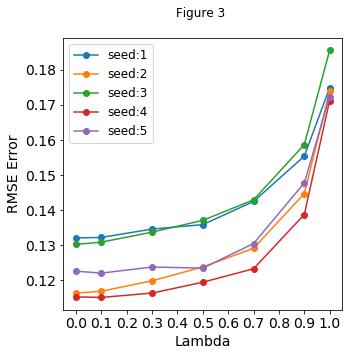

In [625]:
ax_exp1_E6 = exp1_lambda_errors_E6.plot(kind='line', style ='-',marker ="o",fontsize=14,legend=True,figsize=(5,5))

ax_exp1_E6.set_title('Figure 3 \n')
ax_exp1_E6.set_xlabel("Lambda",fontsize=14)
ax_exp1_E6.set_ylabel("RMSE Error",fontsize=14)
ax_exp1_E6.legend(fontsize=12)

#plt.yticks(np.arange(np.round(min(exp1_errors_list),2)-0.01,np.round(max(exp1_errors_list),2)+0.02,0.01))
plt.xticks(np.arange(0,1.1, 0.1))
plt.show()

**Observations**
- as observed from above the, for 5 different seeds the error for all the lambda values vary.
- However the pattern remains the same, that is Lambda 0 gives better performance as compared to the higher values of Lambda, and the performance decrease as we move from 0 to 1 lambda.

Based on the point 1, it is possible, that Sutton had a very specific randomly generated test sets, which is not shared, as it is observed the different patterns can procure slightly different weights.


## Experiment 2

C:\Users\ashup\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\ashup\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3713: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


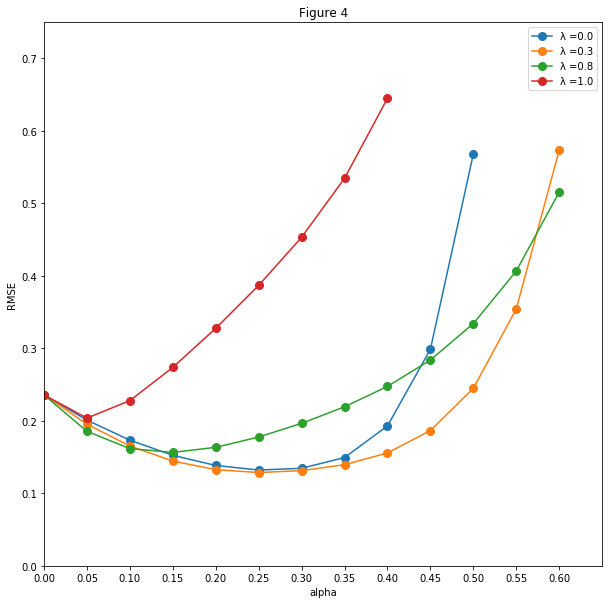

In [225]:
error_alpha_lamda_list  = [experiment_2(Test_Sets=Test_Sets,state = 3, Set_count =100,sequence_count=100, alpha = i, lambda_ = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1] ) for i in np.arange(0,1.1,0.05)]
ex2_error = pd.DataFrame(data = error_alpha_lamda_list, index = np.arange(0,1.1,0.05),  columns =  [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

ex2_error_fig_4  = ex2_error[[0,0.3,0.8,1]]
ex2_error_fig_4[ex2_error_fig_4 > 0.65] = np.nan

ex2_error_fig_4.columns =["λ ="+str(i) for i in ex2_error_fig_4.columns]
ax_exp2 = ex2_error_fig_4.plot(kind='line', style ='-',marker ="o", ms= 8,figsize=(10,10))

ax_exp2.set_title('Figure 4')
ax_exp2.set_xlabel("alpha")
ax_exp2.set_ylabel("RMSE")
#ax_exp2.set_ylim(0,0.8)
#ax_exp2.set_xlim(0,0.65)

ax_exp2.autoscale_view()
#["λ ="+str(i) for i in ex2_error_fig_4.columns]
#,loc='best', fancybox=True, framealpha=1, shadow=True, borderpad=1

plt.ylim(0, 0.75)
plt.xlim(0, 0.65)
plt.yticks(np.arange(0,0.8,0.1))
plt.xticks(np.arange(0,0.65, 0.05))
plt.show()



C:\Users\ashup\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


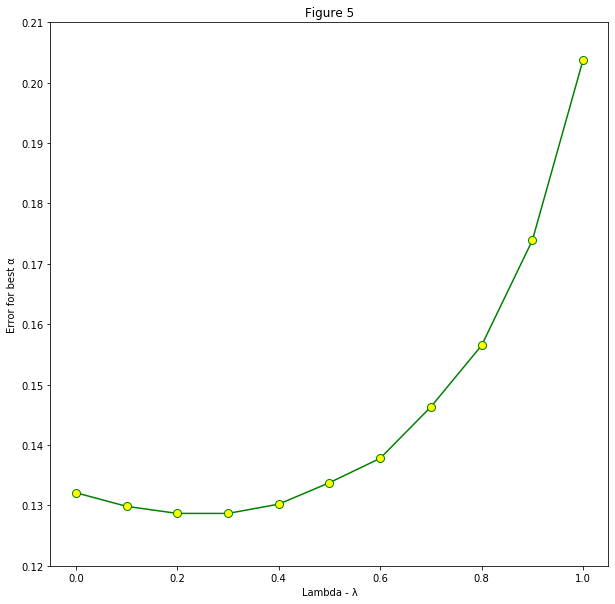

In [226]:
t = ex2_error.apply(lambda x : x.idxmin(), axis =0).reset_index()
t.columns =["lambda","alpha"]
t["error"]= 0

for i in t.to_records():
    t["error"].loc[i[0]] = ex2_error.loc[i[2],i[1]]

ax_fig5 = t.plot(x = "lambda", y = 'error', kind='line', style ='-',color="green",marker ="o",
                                  markerfacecolor='yellow', ms= 8,legend=False,figsize=(10,10))

ax_fig5.set_title('Figure 5')
ax_fig5.set_xlabel("Lambda - λ")
ax_fig5.set_ylabel("Error for best α")

plt.yticks(np.arange(np.round(min(t['error']),2)-0.01,np.round(max(t['error']),2)+0.02,0.01))
#plt.ax_fig5(np.arange(0,1.1, 0.1))
plt.show()


np.round(ex2_error_copy.columns,2)

In [308]:
np.round(ex2_error.columns,2)

Float64Index([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], dtype='float64')

In [357]:
def magnify():
    return [dict(selector="th",props=[("font-size", "10pt")]),dict(selector="td",props=[('padding', "0em 0em")]),
            dict(selector="th:hover",props=[("font-size", "12pt")]),dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),('font-size', '12pt')])
]

In [371]:
ex2_error_copy = ex2_error.T
ex2_error_copy.columns = np.round(ex2_error_copy.columns,2)


ex2_error_copy.sort_index(ascending =False).style.background_gradient(cmap='gnuplot2_r',axis=0)\
    .set_properties(**{'max-width': '80px', 'font-size': '6pt'})\
    .set_caption("Hover to magnify, Rows are λ and columns are α")\
    .format(precision=5)\
    .set_table_styles(magnify())
#gist_earth_r
#gist_stern_r
#gnuplot2_r

,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0,1.05
1.0,0.23570,0.20377,0.22794,0.27377,0.32769,0.38691,0.45327,0.53459,0.64494,0.79864,1.01201,1.34129,1.88382,2.80694,4.41571,7.29593,12.54099,22.09695,39.33466,69.91144,123.18830,220.61318
0.9,0.23570,0.18697,0.17389,0.18200,0.20211,0.22905,0.26031,0.29556,0.33743,0.39028,0.46020,0.55546,0.69002,0.89571,1.22604,1.76775,2.67418,4.27488,7.06115,11.79682,19.71890,33.07924
0.8,0.23570,0.18546,0.16169,0.15649,0.16345,0.17768,0.19652,0.21937,0.24745,0.28386,0.33413,0.40663,0.51551,0.68873,0.96805,1.42598,2.17077,3.37961,5.33507,8.46120,13.40378,21.23594
0.7,0.23570,0.18672,0.15849,0.14643,0.14632,0.15395,0.16644,0.18287,0.20406,0.23314,0.27588,0.34198,0.45050,0.63619,0.95360,1.51027,2.48301,4.16019,6.98763,11.66234,19.28780,31.53263
0.6,0.23570,0.18877,0.15865,0.14257,0.13779,0.14113,0.14973,0.16248,0.18010,0.20604,0.24665,0.31368,0.43259,0.64628,1.02786,1.70469,2.92972,5.09948,8.81186,15.12367,25.52453,42.28832
0.5,0.23570,0.19101,0.16029,0.14180,0.13376,0.13397,0.13989,0.15038,0.16629,0.19175,0.23421,0.30862,0.44908,0.70956,1.18850,2.05380,3.58734,6.31041,11.16203,19.32671,32.70932,54.13036
0.4,0.23570,0.19323,0.16261,0.14271,0.13238,0.13021,0.13420,0.14325,0.15865,0.18572,0.23390,0.32286,0.49637,0.82721,1.45071,2.59824,4.65681,8.25444,14.42942,24.80527,42.03891,69.99189
0.3,0.23570,0.19535,0.16523,0.14455,0.13264,0.12867,0.13128,0.13953,0.15569,0.18655,0.24475,0.35417,0.57319,1.00093,1.82349,3.36306,6.16280,11.10517,19.59448,33.96535,57.72479,95.90522
0.2,0.23570,0.19735,0.16794,0.14691,0.13394,0.12867,0.13040,0.13864,0.15796,0.19800,0.27636,0.41857,0.69915,1.25604,2.33740,4.38374,8.37704,15.84795,29.17879,52.38773,91.97799,157.43047
0.1,0.23570,0.19922,0.17065,0.14957,0.13593,0.12984,0.13132,0.14124,0.16721,0.22428,0.33790,0.54432,0.96626,1.94432,4.11263,8.59601,17.46730,34.35088,65.55960,121.44836,219.17550,383.91373


In [372]:
ex2_error_copy.sort_index(ascending =False).style.background_gradient(cmap='nipy_spectral_r',axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '6pt'})\
    .set_caption("Hover to magnify, Rows are λ and columns are α")\
    .format(precision=5)\
    .set_table_styles(magnify())

,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0,1.05
1.0,0.23570,0.20377,0.22794,0.27377,0.32769,0.38691,0.45327,0.53459,0.64494,0.79864,1.01201,1.34129,1.88382,2.80694,4.41571,7.29593,12.54099,22.09695,39.33466,69.91144,123.18830,220.61318
0.9,0.23570,0.18697,0.17389,0.18200,0.20211,0.22905,0.26031,0.29556,0.33743,0.39028,0.46020,0.55546,0.69002,0.89571,1.22604,1.76775,2.67418,4.27488,7.06115,11.79682,19.71890,33.07924
0.8,0.23570,0.18546,0.16169,0.15649,0.16345,0.17768,0.19652,0.21937,0.24745,0.28386,0.33413,0.40663,0.51551,0.68873,0.96805,1.42598,2.17077,3.37961,5.33507,8.46120,13.40378,21.23594
0.7,0.23570,0.18672,0.15849,0.14643,0.14632,0.15395,0.16644,0.18287,0.20406,0.23314,0.27588,0.34198,0.45050,0.63619,0.95360,1.51027,2.48301,4.16019,6.98763,11.66234,19.28780,31.53263
0.6,0.23570,0.18877,0.15865,0.14257,0.13779,0.14113,0.14973,0.16248,0.18010,0.20604,0.24665,0.31368,0.43259,0.64628,1.02786,1.70469,2.92972,5.09948,8.81186,15.12367,25.52453,42.28832
0.5,0.23570,0.19101,0.16029,0.14180,0.13376,0.13397,0.13989,0.15038,0.16629,0.19175,0.23421,0.30862,0.44908,0.70956,1.18850,2.05380,3.58734,6.31041,11.16203,19.32671,32.70932,54.13036
0.4,0.23570,0.19323,0.16261,0.14271,0.13238,0.13021,0.13420,0.14325,0.15865,0.18572,0.23390,0.32286,0.49637,0.82721,1.45071,2.59824,4.65681,8.25444,14.42942,24.80527,42.03891,69.99189
0.3,0.23570,0.19535,0.16523,0.14455,0.13264,0.12867,0.13128,0.13953,0.15569,0.18655,0.24475,0.35417,0.57319,1.00093,1.82349,3.36306,6.16280,11.10517,19.59448,33.96535,57.72479,95.90522
0.2,0.23570,0.19735,0.16794,0.14691,0.13394,0.12867,0.13040,0.13864,0.15796,0.19800,0.27636,0.41857,0.69915,1.25604,2.33740,4.38374,8.37704,15.84795,29.17879,52.38773,91.97799,157.43047
0.1,0.23570,0.19922,0.17065,0.14957,0.13593,0.12984,0.13132,0.14124,0.16721,0.22428,0.33790,0.54432,0.96626,1.94432,4.11263,8.59601,17.46730,34.35088,65.55960,121.44836,219.17550,383.91373
